In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  RobustScaler

# Model
from sklearn.cluster import KMeans
from hmmlearn.hmm import GaussianHMM

In [3]:
file_path = '../data/processed/reliance_anomaly.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,Date,Close,High,Low,Open,Volume,Return,volume_ratio,price_gap,return_volatility,return_zscore,Bollinger_%B,Volume_Z,OBV,RSI,MACD_Hist,ATR,anomaly_score,is_anomaly
0,2010-07-01,234.642654,236.844639,232.516974,236.332295,13310905,-0.012479,0.734391,-1.275402,0.015178,-0.678688,0.722718,-0.676549,83612828.0,58.289360,2.794933,5.093850,0.163253,1
1,2010-07-02,233.051102,236.321376,232.255327,234.588133,10948784,-0.006783,0.609344,-0.054521,0.015309,-0.358309,0.638755,-0.969118,72664044.0,51.600585,2.625827,5.016766,0.166388,1
2,2010-07-05,232.909378,233.966768,231.688479,233.280014,6399512,-0.000608,0.363341,0.228912,0.014192,-0.046613,0.613671,-1.468308,66264532.0,50.653578,2.452242,4.871160,0.118779,1
3,2010-07-06,234.130295,235.874438,232.298932,232.298932,9255011,0.005242,0.534528,-0.610446,0.013793,0.251225,0.659523,-1.026802,75519543.0,54.811458,2.384239,4.853252,0.150207,1
4,2010-07-07,229.693619,234.326515,229.137672,234.152105,13738578,-0.018950,0.796940,0.021811,0.014587,-1.116172,0.346104,-0.444404,61780965.0,44.830593,1.954588,4.927222,0.147774,1


##### Feature Engineering

In [5]:
df_feature = df.copy()

In [6]:
# Create moving averages
df_feature['ma_fast'] = df_feature['Close'].rolling(window=10).mean()
df_feature['ma_slow'] = df_feature['Close'].rolling(window=50).mean()
df_feature['ma_diff'] = df_feature['ma_fast'] - df_feature['ma_slow']
df_feature['price_vs_ma50'] = df_feature['Close'] / df_feature['ma_slow']
df_feature['ma_slope'] = df_feature['ma_slow'].diff()

In [7]:
# Rate of Change
df_feature['roc_10'] = df_feature['Close'].pct_change(10)

# Bollinger Bands
rolling_std = df_feature['Close'].rolling(window=20).std()
df_feature['bb_upper'] = df_feature['Close'].rolling(window=20).mean() + (2 * rolling_std)
df_feature['bb_lower'] = df_feature['Close'].rolling(window=20).mean() - (2 * rolling_std)
df_feature['bb_width'] = (df_feature['bb_upper'] - df_feature['bb_lower']) / df_feature['Close'].rolling(window=20).mean()

# RSI slope (rate of change in RSI)
df_feature['rsi_slope'] = df_feature['RSI'].diff()

# Bearishness score
df_feature['bear_score'] = (
    0.4*(df_feature['RSI'] < 35).astype(float) + 
    0.3*(df_feature['MACD_Hist'] < -5).astype(float) + 
    0.3*(df_feature['roc_10'] < -0.03).astype(float)
)


df_feature['bull_strength'] = (df['RSI'] > 60) & (df['MACD_Hist'] > 5)
df_feature['bear_strength'] = (df['RSI'] < 35) & (df['MACD_Hist'] < -5)

In [8]:
df_feature['volatility_spike'] = df_feature['bb_width'] / df_feature['bb_width'].rolling(20).mean()
# Divergence (MACD divergence)
df_feature['divergence'] = np.where(
    (df_feature['MACD_Hist'] > 10) & (df_feature['Return'] < 0),
    1,  # True divergence
    0
)
# 20-period Simple Moving Average (SMA)
df_feature['SMA_20'] = df_feature['Close'].rolling(window=20).mean()
df_feature['SMA_7'] = df_feature['Close'].rolling(window=7).mean()

In [9]:
df_feature.head()

,Date,Close,High,Low,Open,Volume,Return,volume_ratio,price_gap,return_volatility,...,bb_lower,bb_width,rsi_slope,bear_score,bull_strength,bear_strength,volatility_spike,divergence,SMA_20,SMA_7
0,2010-07-01,234.642654,236.844639,232.516974,236.332295,13310905,-0.012479,0.734391,-1.275402,0.015178,...,NaN,NaN,NaN,0.0,False,False,NaN,0,NaN,NaN
1,2010-07-02,233.051102,236.321376,232.255327,234.588133,10948784,-0.006783,0.609344,-0.054521,0.015309,...,NaN,NaN,-6.688775,0.0,False,False,NaN,0,NaN,NaN
2,2010-07-05,232.909378,233.966768,231.688479,233.280014,6399512,-0.000608,0.363341,0.228912,0.014192,...,NaN,NaN,-0.947007,0.0,False,False,NaN,0,NaN,NaN
3,2010-07-06,234.130295,235.874438,232.298932,232.298932,9255011,0.005242,0.534528,-0.610446,0.013793,...,NaN,NaN,4.157880,0.0,False,False,NaN,0,NaN,NaN
4,2010-07-07,229.693619,234.326515,229.137672,234.152105,13738578,-0.018950,0.796940,0.021811,0.014587,...,NaN,NaN,-9.980865,0.0,False,False,NaN,0,NaN,NaN


In [10]:
df_feature = df_feature.dropna()

In [11]:
df_feature.head()

,Date,Close,High,Low,Open,Volume,Return,volume_ratio,price_gap,return_volatility,...,bb_lower,bb_width,rsi_slope,bear_score,bull_strength,bear_strength,volatility_spike,divergence,SMA_20,SMA_7
50,2010-09-09,208.981827,210.867693,208.251470,209.941111,10114309,-0.001094,0.468218,0.730341,0.012949,...,200.936042,0.077887,-4.906543,0.0,False,False,0.833637,0,209.078310,206.571176
51,2010-09-13,216.383575,217.037627,210.464361,211.914188,27474309,0.035418,1.280865,2.932361,0.015203,...,200.657236,0.081894,15.580189,0.0,False,False,0.893566,0,209.224384,208.324668
52,2010-09-14,215.435196,218.672769,214.606734,217.037631,19472955,-0.004383,0.896461,0.654056,0.015233,...,200.488112,0.084634,0.050844,0.0,False,False,0.941244,0,209.347020,209.903748
53,2010-09-15,221.049194,222.095684,215.620523,215.620523,33554695,0.026059,1.480769,0.185327,0.016141,...,199.557568,0.097808,7.729995,0.0,False,False,1.102244,0,209.818486,212.650787
54,2010-09-16,218.095032,221.365321,217.408278,220.656752,18540979,-0.013364,0.829782,-0.392443,0.016416,...,199.298599,0.103798,-0.743582,0.0,False,False,1.181411,0,210.208195,214.136431


In [12]:
df_feature.isnull().sum()

Date                 0
Close                0
High                 0
Low                  0
Open                 0
Volume               0
Return               0
volume_ratio         0
price_gap            0
return_volatility    0
return_zscore        0
Bollinger_%B         0
Volume_Z             0
OBV                  0
RSI                  0
MACD_Hist            0
ATR                  0
anomaly_score        0
is_anomaly           0
ma_fast              0
ma_slow              0
ma_diff              0
price_vs_ma50        0
ma_slope             0
roc_10               0
bb_upper             0
bb_lower             0
bb_width             0
rsi_slope            0
bear_score           0
bull_strength        0
bear_strength        0
volatility_spike     0
divergence           0
SMA_20               0
SMA_7                0
dtype: int64

In [13]:
# Select relevant features
X = df_feature[[
    'RSI',                
    'MACD_Hist',          
    'price_vs_ma50',        
    'volatility_spike',     
    'bull_strength',      
    'bear_score',             
    'ma_diff',                          
    'SMA_7',
]]

# Standardize the features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
model = GaussianHMM(
    n_components=4,
    covariance_type="full",  
    n_iter=2000,
    random_state=42,
    init_params="stmc",  # Let it initialize means/transitions
    params="stmc",        # Allow all parameters to be trained
     tol=1e-3,
     min_covar=1e-3
)

model.fit(X_scaled)

Model is not converging.  Current: 8811.166244084914 is not greater than 26586.24148829673. Delta is -17775.075244211817


GaussianHMM(covariance_type='full', n_components=4, n_iter=2000,
            random_state=42, tol=0.001)

In [15]:
hidden_states = model.predict(X_scaled)

In [16]:
hidden_states

array([0, 0, 0, ..., 3, 3, 3])

In [17]:
print(f"Log-Likelihood: {model.score(X_scaled)}")
print(f"AIC: {model.aic(X_scaled)}")
print(f"BIC: {model.bic(X_scaled)}")

Log-Likelihood: 27295.076502414202
AIC: -54208.153004828404
BIC: -53026.00730041285


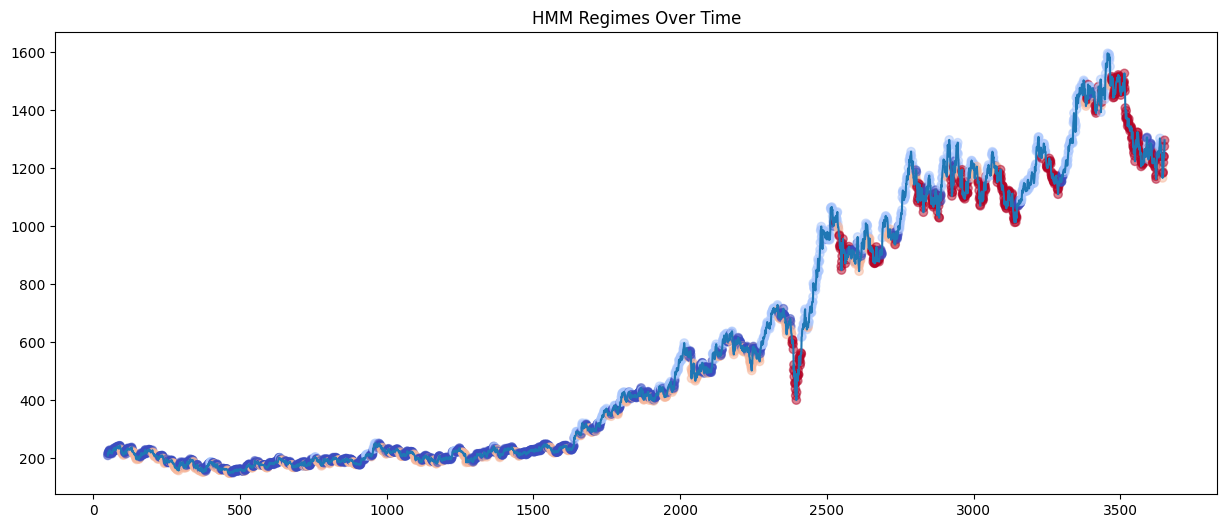

In [18]:
plt.figure(figsize=(15,6))
plt.plot(df_feature.index, df_feature['Close'], label='Close Price')
plt.scatter(df_feature.index, df_feature['Close'], c=hidden_states, cmap='coolwarm', alpha=0.5)
plt.title("HMM Regimes Over Time")
plt.show()


In [19]:
print(pd.Series(hidden_states).value_counts())

0    1433
1     829
2     807
3     533
Name: count, dtype: int64


In [20]:
regime_stats = pd.DataFrame({
    'Returns': df_feature['Return'],
    'Regime': model.predict(X_scaled)
}).groupby('Regime')['Returns'].agg(['mean', 'std', 'count'])
print(regime_stats.sort_values('mean', ascending=False))

            mean       std  count
Regime                           
1       0.002854  0.016357    829
0       0.002521  0.015533   1433
3      -0.000002  0.021230    533
2      -0.004483  0.017189    807


In [21]:
df_feature['Regime'] = hidden_states

In [22]:
regime_map = {
    1: "Strong Bull",     
    0: "Mild Bull",
    2: "Strong Bear",
    3: "Mild Bear"
}
df_feature['Regime_Label'] = df_feature['Regime'].map(regime_map)

In [23]:
df_feature.head()

,Date,Close,High,Low,Open,Volume,Return,volume_ratio,price_gap,return_volatility,...,rsi_slope,bear_score,bull_strength,bear_strength,volatility_spike,divergence,SMA_20,SMA_7,Regime,Regime_Label
50,2010-09-09,208.981827,210.867693,208.251470,209.941111,10114309,-0.001094,0.468218,0.730341,0.012949,...,-4.906543,0.0,False,False,0.833637,0,209.078310,206.571176,0,Mild Bull
51,2010-09-13,216.383575,217.037627,210.464361,211.914188,27474309,0.035418,1.280865,2.932361,0.015203,...,15.580189,0.0,False,False,0.893566,0,209.224384,208.324668,0,Mild Bull
52,2010-09-14,215.435196,218.672769,214.606734,217.037631,19472955,-0.004383,0.896461,0.654056,0.015233,...,0.050844,0.0,False,False,0.941244,0,209.347020,209.903748,0,Mild Bull
53,2010-09-15,221.049194,222.095684,215.620523,215.620523,33554695,0.026059,1.480769,0.185327,0.016141,...,7.729995,0.0,False,False,1.102244,0,209.818486,212.650787,0,Mild Bull
54,2010-09-16,218.095032,221.365321,217.408278,220.656752,18540979,-0.013364,0.829782,-0.392443,0.016416,...,-0.743582,0.0,False,False,1.181411,0,210.208195,214.136431,0,Mild Bull


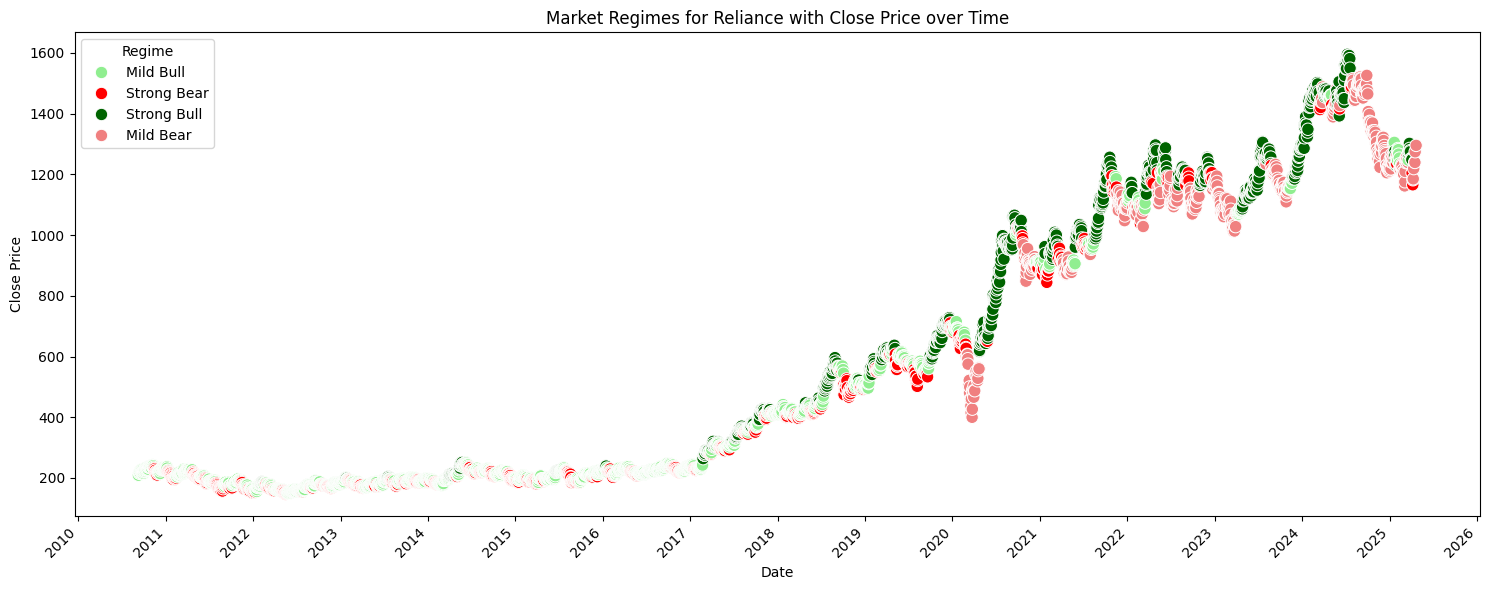

In [24]:
import matplotlib.dates as mdates

df_feature['Date'] = pd.to_datetime(df_feature['Date'])
regime_colors = {
    "Strong Bull": "darkgreen",
    "Mild Bull": "lightgreen",
    "Strong Bear": "red",
    "Mild Bear": "lightcoral"
}

plt.figure(figsize=(15, 6))

# Scatter plot with regime colors
sns.scatterplot(
    x=df_feature['Date'],
    y=df_feature['Close'],
    hue=df_feature['Regime_Label'],
    palette=regime_colors,
    legend='full',
    s=80,  # size of points
    marker='o'
)

# Set plot labels and title
plt.title("Market Regimes for Reliance with Close Price over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")

# Display the legend
plt.legend(title='Regime', loc='upper left')

# Format the x-axis to show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45, ha='right') # Rotate for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [25]:
df_feature['Date'].info()

<class 'pandas.core.series.Series'>
Index: 3602 entries, 50 to 3651
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
3602 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 56.3 KB


#### Evaluating  model Performance based on known events.

In [51]:
data = {
    'Date': ['2020-03-16', '2020-04-23', '2016-09-06', '2020-05-18', '2017-09-18','2020-03-23','2019-02-1'],
    'Event': [
        'Initial COVID crash',
        'Facebook investment in Reliance',
        'Launch of Jio',
        'Reliance has positive news and continues investing (Facebook investment)',
        'Uptrend based on NSE',
        'COVID',
        'Q4 result postive'
    ]
}

df_news_collected = pd.DataFrame(data)
df_news_collected 


,Date,Event
0,2020-03-16,Initial COVID crash
1,2020-04-23,Facebook investment in Reliance
2,2016-09-06,Launch of Jio
3,2020-05-18,Reliance has positive news and continues inves...
4,2017-09-18,Uptrend based on NSE
5,2020-03-23,COVID
6,2019-02-1,Q4 result postive


#### Bear Market

In [52]:
bear_day_1 = df_feature[df_feature['Date'] == pd.to_datetime('2020-03-16')]['Regime_Label'].iloc[0]
bear_day_2 = df_feature[df_feature['Date'] == pd.to_datetime('2020-03-23')]['Regime_Label'].iloc[0]
print(f"Regime on 2020-03-16: {bear_day_1}")
print(f"Regime on 2020-03-23: {bear_day_2}")

Regime on 2020-03-16: Mild Bear
Regime on 2020-03-23: Mild Bear


##### Bull Market

In [53]:
bull_day_1 = df_feature[df_feature['Date'] == pd.to_datetime('2020-04-23')]['Regime_Label'].iloc[0] 
bull_day_2 = df_feature[df_feature['Date'] == pd.to_datetime('2016-09-06')]['Regime_Label'].iloc[0]
bull_day_3 = df_feature[df_feature['Date'] == pd.to_datetime('2020-05-18')]['Regime_Label'].iloc[0]
bull_day_4= df_feature[df_feature['Date'] == pd.to_datetime('2017-09-18')]['Regime_Label'].iloc[0]
bull_day_5= df_feature[df_feature['Date'] == pd.to_datetime('2019-02-01')]['Regime_Label'].iloc[0]

print(f"Regime on 2020-04-23: {bull_day_1}")
print(f"Regime on 2016-09-06: {bull_day_2}")
print(f"Regime on 2016-09-06: {bull_day_3}")
print(f"Regime on 2016-09-06: {bull_day_4}")
print(f"Regime on 2019-02-01: {bull_day_5}")

Regime on 2020-04-23: Strong Bull
Regime on 2016-09-06: Mild Bull
Regime on 2016-09-06: Strong Bull
Regime on 2016-09-06: Strong Bull
Regime on 2019-02-01: Strong Bull


#### Save Our Model

In [41]:
import joblib

# Save the GMM model
joblib.dump(model, 'F:/Xai_trader/model/rel_regime_gmm_model.pkl')
# Optionally, you can also save the scaler if you want to scale new data in the future using the same scaler
joblib.dump(scaler, 'F:/Xai_trader/model/rel_scaler.pkl')


['F:/Xai_trader/model/rel_scaler.pkl']

In [42]:
df_feature.shape

(3602, 38)

In [54]:
df_feature.head()

,Date,Close,High,Low,Open,Volume,Return,volume_ratio,price_gap,return_volatility,...,rsi_slope,bear_score,bull_strength,bear_strength,volatility_spike,divergence,SMA_20,SMA_7,Regime,Regime_Label
50,2010-09-09,208.981827,210.867693,208.251470,209.941111,10114309,-0.001094,0.468218,0.730341,0.012949,...,-4.906543,0.0,False,False,0.833637,0,209.078310,206.571176,0,Mild Bull
51,2010-09-13,216.383575,217.037627,210.464361,211.914188,27474309,0.035418,1.280865,2.932361,0.015203,...,15.580189,0.0,False,False,0.893566,0,209.224384,208.324668,0,Mild Bull
52,2010-09-14,215.435196,218.672769,214.606734,217.037631,19472955,-0.004383,0.896461,0.654056,0.015233,...,0.050844,0.0,False,False,0.941244,0,209.347020,209.903748,0,Mild Bull
53,2010-09-15,221.049194,222.095684,215.620523,215.620523,33554695,0.026059,1.480769,0.185327,0.016141,...,7.729995,0.0,False,False,1.102244,0,209.818486,212.650787,0,Mild Bull
54,2010-09-16,218.095032,221.365321,217.408278,220.656752,18540979,-0.013364,0.829782,-0.392443,0.016416,...,-0.743582,0.0,False,False,1.181411,0,210.208195,214.136431,0,Mild Bull


In [55]:
df_feature.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return',
       'volume_ratio', 'price_gap', 'return_volatility', 'return_zscore',
       'Bollinger_%B', 'Volume_Z', 'OBV', 'RSI', 'MACD_Hist', 'ATR',
       'anomaly_score', 'is_anomaly', 'ma_fast', 'ma_slow', 'ma_diff',
       'price_vs_ma50', 'ma_slope', 'roc_10', 'bb_upper', 'bb_lower',
       'bb_width', 'rsi_slope', 'bear_score', 'bull_strength', 'bear_strength',
       'volatility_spike', 'divergence', 'SMA_20', 'SMA_7', 'Regime',
       'Regime_Label'],
      dtype='object')

In [56]:
file_path = r'F:\Xai_trader\data\processed\regime_and_anomaly.csv'
df_feature.to_csv(file_path,index=False)
print(f"Regime anomaly combined data saved at :{file_path}")

Regime anomaly combined data saved at :F:\Xai_trader\data\processed\regime_and_anomaly.csv
